In [86]:
import pandas as pd
import re
from string import punctuation
from nltk.corpus import stopwords
from nltk.probability import FreqDist
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
import itertools
import matplotlib.pyplot as plt
from wordcloud import WordCloud

In [146]:
df = pd.read_csv('tweet_covid_dataset.csv')

In [88]:
df['Tweet']

0      @jokowi Kami sekeluarga dari awal covid sdh pr...
1      Pemerintah 'Nunggak' Bayar Klaim Covid-19 ke R...
2      @CTNurza @DoktorSamhan Masalahnya manusia yg t...
3      Ketawa saja bung @Dennysiregar7 , mereka itu o...
4      Aku iki cuma overthinking ae. Gumun juga klo n...
                             ...                        
995    @CNNIndonesia Dalam keadaan darurat, prosesnya...
996    @zouloutchaaaing rohi diri lvaccin hari denya ...
997    TNI-Polri bagikan Masker kepada masyarakat gun...
998    Hallo Sobat Polri... anak-anak sangat rentan t...
999    Bupati Karawang Cellica Nurrachadiana Kembali ...
Name: Tweet, Length: 1000, dtype: object

# Pre-Processing

## Cleaning

In [147]:
def clean_data(text):
    text = re.sub('@([a-zA-Z0-9_]+)', '', text) #remove @mention
    text = re.sub('#[\s]+', '', text) #remove hashtag
    text = re.sub('RT[\s]+', '', text) #remove RT
    text = re.sub('https?:\/\/\S+', '', text) #remove hyperlink
    text = re.sub('\d+', '', text) #remove number
    text = re.sub('[^\w\s]', '', text) #remove punctuations
    text = re.sub(r'\b[a-zA-Z]\b', '', text) #remove single character
    text = re.sub('\n', '', text) #remove \n
    text = re.sub('\r', '', text) #remove \r
    text = text.lower() #lowercase
    text = text.strip() #remove whitespace
    return text

In [149]:
df['Tweet'] = df['Tweet'].apply(clean_data)

In [150]:
df['Tweet']

0      kami sekeluarga dari awal covid sdh prokes pak...
1          pemerintah nunggak bayar klaim covid ke rs rp
2      masalahnya manusia yg tak berakal tidak berota...
3      ketawa saja bung   mereka itu orangorang yg ku...
4      aku iki cuma overthinking ae gumun juga klo nd...
                             ...                        
995    dalam keadaan darurat prosesnya jangan lama bu...
996           rohi diri lvaccin hari denya kaml bl covid
997    tnipolri bagikan masker kepada masyarakat guna...
998    hallo sobat polri anakanak sangat rentan terha...
999    bupati karawang cellica nurrachadiana kembali ...
Name: Tweet, Length: 1000, dtype: object

## Stopword

In [32]:
#Stopword from custom data
alay = pd.read_csv('colloquial-indonesian-lexicon.csv')
#Memisahkan kalimat menjadi kata
slang = [word_tokenize(text) for text in alay['slang']]
slang

[['woww'],
 ['aminn'],
 ['met'],
 ['netaas'],
 ['keberpa'],
 ['eeeehhhh'],
 ['kata2nyaaa'],
 ['hallo'],
 ['kaka'],
 ['ka'],
 ['daah'],
 ['aaaaahhhh'],
 ['yaa'],
 ['smga'],
 ['slalu'],
 ['amiin'],
 ['kk'],
 ['trus'],
 ['kk'],
 ['sii'],
 ['nyenengin'],
 ['bgt'],
 ['gemess'],
 ['akuuu'],
 ['jgn'],
 ['yaa'],
 ['udah'],
 ['gitu'],
 ['aja'],
 ['gemesiin'],
 ['menyenangkn'],
 ['rb'],
 ['akau'],
 ['saranin'],
 ['nemuin'],
 ['yah'],
 ['met'],
 ['mnis2nya'],
 ['gtu'],
 ['tu'],
 ['idolaa'],
 ['bangett'],
 ['kaakk'],
 ['baaiikkk'],
 ['telaatt'],
 ['kaak'],
 ['yg'],
 ['lg'],
 ['skarang'],
 ['yg'],
 ['sempet'],
 ['karna'],
 ['ngga'],
 ['karna'],
 ['mantep'],
 ['loohhh'],
 ['yeee'],
 ['baguuuuus'],
 ['sampe'],
 ['ngikutin'],
 ['gayany'],
 ['ngikutin'],
 ['lg'],
 ['bnk'],
 ['awaas'],
 ['siip'],
 ['abizzzz'],
 ['kerrrrennnn'],
 ['sayaa'],
 ['pengen'],
 ['kpan'],
 ['bgt'],
 ['sma'],
 ['sdkit'],
 ['bngt'],
 ['lgu'],
 ['bener2'],
 ['kharismanya'],
 ['aq'],
 ['yg'],
 ['jdi'],
 ['lgi'],
 ['gk'],
 ['kek'],
 

In [63]:
alay

,slang,formal,In-dictionary,context,category1,category2,category3
0,woww,wow,1,wow,elongasi,0,0
1,aminn,amin,1,Selamat ulang tahun kakak tulus semoga panjang...,elongasi,0,0
2,met,selamat,1,Met hari netaas kak!? Wish you all the best @t...,abreviasi,0,0
3,netaas,menetas,1,Met hari netaas kak!? Wish you all the best @t...,afiksasi,elongasi,0
4,keberpa,keberapa,0,Birthday yg keberpa kak?,abreviasi,0,0
...,...,...,...,...,...,...,...
15001,gataunya,enggak taunya,0,Ini kaya nenek2 ya beb gataunya agnezz @yugime...,akronim,0,0
15002,gtau,enggak tau,0,Stidaknya mrka may berkarya Dan berusaha yg tr...,akronim,abreviasi,0
15003,gatau,enggak tau,0,Ih gatau malu,akronim,0,0
15004,fans2,fan-fan,0,Jkt48 adalah tempat di mana sesama fans saling...,reduplikasi,naturalisasi,0


In [33]:
#Merubah list dalam list menjadi 1 list
slang_ = list(itertools.chain.from_iterable(slang))
slang_

['woww',
 'aminn',
 'met',
 'netaas',
 'keberpa',
 'eeeehhhh',
 'kata2nyaaa',
 'hallo',
 'kaka',
 'ka',
 'daah',
 'aaaaahhhh',
 'yaa',
 'smga',
 'slalu',
 'amiin',
 'kk',
 'trus',
 'kk',
 'sii',
 'nyenengin',
 'bgt',
 'gemess',
 'akuuu',
 'jgn',
 'yaa',
 'udah',
 'gitu',
 'aja',
 'gemesiin',
 'menyenangkn',
 'rb',
 'akau',
 'saranin',
 'nemuin',
 'yah',
 'met',
 'mnis2nya',
 'gtu',
 'tu',
 'idolaa',
 'bangett',
 'kaakk',
 'baaiikkk',
 'telaatt',
 'kaak',
 'yg',
 'lg',
 'skarang',
 'yg',
 'sempet',
 'karna',
 'ngga',
 'karna',
 'mantep',
 'loohhh',
 'yeee',
 'baguuuuus',
 'sampe',
 'ngikutin',
 'gayany',
 'ngikutin',
 'lg',
 'bnk',
 'awaas',
 'siip',
 'abizzzz',
 'kerrrrennnn',
 'sayaa',
 'pengen',
 'kpan',
 'bgt',
 'sma',
 'sdkit',
 'bngt',
 'lgu',
 'bener2',
 'kharismanya',
 'aq',
 'yg',
 'jdi',
 'lgi',
 'gk',
 'kek',
 'lgunya',
 'kpan',
 'kereeeeennnn',
 'nyamain',
 'slalu',
 'lakik',
 'siippp',
 'bkn',
 'nyangka',
 'bangettt',
 'kereeen',
 'wihhhhhh',
 'tp',
 'inget',
 'bingitsss',


In [34]:
#Memisahkan kalimat menjadi kata
formal = [word_tokenize(text) for text in alay['formal']]
formal

[['wow'],
 ['amin'],
 ['selamat'],
 ['menetas'],
 ['keberapa'],
 ['eh'],
 ['kata-katanya'],
 ['halo'],
 ['kakak'],
 ['kak'],
 ['dah'],
 ['ah'],
 ['ya'],
 ['semoga'],
 ['selalu'],
 ['amin'],
 ['kakak'],
 ['terus'],
 ['kakak'],
 ['sih'],
 ['menyenangkan'],
 ['banget'],
 ['gemas'],
 ['aku'],
 ['jangan'],
 ['ya'],
 ['sudah'],
 ['begitu'],
 ['saja'],
 ['menggemaskan'],
 ['menyenangkan'],
 ['ribu'],
 ['aku'],
 ['menyarankan'],
 ['menemukan'],
 ['ya'],
 ['selamat'],
 ['manis-manisnya'],
 ['begitu'],
 ['itu'],
 ['idola'],
 ['banget'],
 ['kak'],
 ['baik'],
 ['telat'],
 ['kak'],
 ['yang'],
 ['lagi'],
 ['sekarang'],
 ['yang'],
 ['sempat'],
 ['karena'],
 ['enggak'],
 ['karena'],
 ['mantap'],
 ['loh'],
 ['ya'],
 ['bagus'],
 ['sampai'],
 ['mengikuti'],
 ['gayanya'],
 ['mengikuti'],
 ['lagi'],
 ['bang'],
 ['awas'],
 ['sip'],
 ['habis'],
 ['keren'],
 ['saya'],
 ['pengin'],
 ['kapan'],
 ['banget'],
 ['sama'],
 ['sedikit'],
 ['banget'],
 ['lagu'],
 ['benar-benar'],
 ['karismanya'],
 ['aku'],
 ['yang'],


In [35]:
#Merubah list dalam list menjadi 1 list
formal_ = list(itertools.chain.from_iterable(slang))
formal_

['woww',
 'aminn',
 'met',
 'netaas',
 'keberpa',
 'eeeehhhh',
 'kata2nyaaa',
 'hallo',
 'kaka',
 'ka',
 'daah',
 'aaaaahhhh',
 'yaa',
 'smga',
 'slalu',
 'amiin',
 'kk',
 'trus',
 'kk',
 'sii',
 'nyenengin',
 'bgt',
 'gemess',
 'akuuu',
 'jgn',
 'yaa',
 'udah',
 'gitu',
 'aja',
 'gemesiin',
 'menyenangkn',
 'rb',
 'akau',
 'saranin',
 'nemuin',
 'yah',
 'met',
 'mnis2nya',
 'gtu',
 'tu',
 'idolaa',
 'bangett',
 'kaakk',
 'baaiikkk',
 'telaatt',
 'kaak',
 'yg',
 'lg',
 'skarang',
 'yg',
 'sempet',
 'karna',
 'ngga',
 'karna',
 'mantep',
 'loohhh',
 'yeee',
 'baguuuuus',
 'sampe',
 'ngikutin',
 'gayany',
 'ngikutin',
 'lg',
 'bnk',
 'awaas',
 'siip',
 'abizzzz',
 'kerrrrennnn',
 'sayaa',
 'pengen',
 'kpan',
 'bgt',
 'sma',
 'sdkit',
 'bngt',
 'lgu',
 'bener2',
 'kharismanya',
 'aq',
 'yg',
 'jdi',
 'lgi',
 'gk',
 'kek',
 'lgunya',
 'kpan',
 'kereeeeennnn',
 'nyamain',
 'slalu',
 'lakik',
 'siippp',
 'bkn',
 'nyangka',
 'bangettt',
 'kereeen',
 'wihhhhhh',
 'tp',
 'inget',
 'bingitsss',


In [160]:
#remove stopwords
raw = df['Tweet']
dff = [word_tokenize(paragraf) for paragraf in raw]
from nltk.corpus import stopwords
indo = stopwords.words('indonesian')
indo.extend(['yg','nya', 'dgn', 'dg', 'dr', 'ya', 'yaa', 
             'aja', 'utk', 'ni', 'tp', 'amp', 'dah', 'krn'
             ,'udah'])
indo.extend(slang_)
indo.extend(formal_)
hasil_stopword = []  
for i in range(len(dff)):
    data = [word for word in dff[i][:] if word not in indo]
    hasil_stopword.append(data)

hasil_join = []
for join in range(len(hasil_stopword)):
    hasil_join.append(' '.join(hasil_stopword[join]))
clean_data = hasil_join

In [159]:
print('before :'+str(len(dff[0])))
print('after :'+str(len(hasil_stopword[0])))

before :39
after :18


In [65]:
#Mengetahui banyaknya kata yg muncul
df_token = [word_tokenize(paragraf) for paragraf in clean_data]
iter_= list(itertools.chain(*df_token))
fqdist = FreqDist(iter_)
fqdist.most_common(50)

[('covid', 661),
 ('covid19', 347),
 ('kena', 109),
 ('ppkm', 101),
 ('vaksin', 100),
 ('pandemi', 72),
 ('pemerintah', 60),
 ('positif', 54),
 ('darurat', 53),
 ('masyarakat', 52),
 ('sakit', 49),
 ('penanganan', 48),
 ('indonesia', 46),
 ('percaya', 45),
 ('meninggal', 45),
 ('virus', 44),
 ('penyebaran', 44),
 ('rumah', 43),
 ('kalo', 41),
 ('warga', 39),
 ('kematian', 35),
 ('semoga', 34),
 ('desa', 32),
 ('prokes', 31),
 ('negara', 31),
 ('rakyat', 30),
 ('juli', 29),
 ('kesehatan', 29),
 ('rs', 27),
 ('sembuh', 27),
 ('pas', 27),
 ('tau', 27),
 ('gue', 27),
 ('pagi', 27),
 ('masuk', 26),
 ('allah', 24),
 ('berita', 24),
 ('banget', 24),
 ('akibat', 23),
 ('turun', 23),
 ('angka', 23),
 ('protokol', 23),
 ('keluarga', 22),
 ('gejala', 22),
 ('masker', 21),
 ('nak', 20),
 ('corona', 20),
 ('jawa', 20),
 ('terpapar', 19),
 ('ruang', 19)]

In [66]:
clean_data_save = pd.DataFrame({'Tweet':clean_data})
clean_data_save.to_csv('data_clean_tweet.csv')

# Workcloud

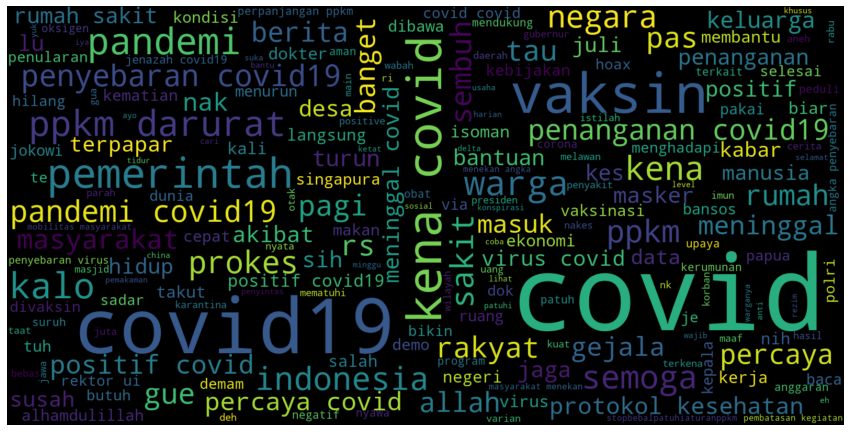

In [67]:
paragraf = ' '.join(clean_data)
wordcloud = WordCloud(width=1600, height=800, max_font_size=200).generate(paragraf)
plt.figure(figsize=(15,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

# Feature Extraction

## Count Vectorizer (Bag of Words)

In [161]:
cv = CountVectorizer()
x_sentence = cv.fit_transform(clean_data)

In [162]:
cv.get_feature_names()

['aa',
 'aamiintambahimun',
 'aamiintruestory',
 'abah',
 'abai',
 'abaikan',
 'abamaze',
 'abang',
 'abdurachman',
 'abiszzzz',
 'acara',
 'acc',
 'aceh',
 'adab',
 'adadikompas',
 'adakah',
 'adek',
 'adem',
 'adha',
 'adhyaksa',
 'adhyaksasinergitas',
 'adik',
 'adikku',
 'adipuratabanan',
 'adisasmito',
 'adisasmitomeminta',
 'administrasi',
 'ads',
 'adu',
 'aduhai',
 'aeeee',
 'aekarang',
 'afiat',
 'afrika',
 'afsel',
 'after',
 'agama',
 'agenda',
 'agensi',
 'agi',
 'agr',
 'agustus',
 'ah',
 'ahli',
 'ahmad',
 'aidiladha',
 'aifatihah',
 'ain',
 'aing',
 'aiptu',
 'air',
 'airlangga',
 'ais',
 'ajaib',
 'ajak',
 'ajakah',
 'ajal',
 'ajg',
 'akal',
 'akhirat',
 'aki',
 'akibat',
 'akil',
 'aksa',
 'aksi',
 'aksinyatatanganipandemi',
 'aktif',
 'aktiv',
 'aktivis',
 'aktivitas',
 'aktivitiaktiviti',
 'aktivity',
 'aktor',
 'akui',
 'akuin',
 'akuntable',
 'alam',
 'alami',
 'alamin',
 'alasan',
 'alasannya',
 'alaskan',
 'alat',
 'alay',
 'alfatihah',
 'algoritma',
 'alhamdulil

In [163]:
x_sentence.toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [164]:
x_sentence_df = pd.DataFrame(x_sentence.toarray(), columns=cv.get_feature_names())

In [165]:
x_sentence_df

,aa,aamiintambahimun,aamiintruestory,abah,abai,abaikan,abamaze,abang,abdurachman,abiszzzz,...,yustisi,yusuf,yuuuuu,zaman,zayed,zodiak,zona,zonasi,zubaidah,ಠಠ
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [47]:
x_sentence_df.to_csv('count_vectorizer.csv')

## Tfidf Vectorizer

In [166]:
tfidf = TfidfVectorizer()
x2_sentence = tfidf.fit_transform(clean_data)

In [167]:
x2_sentence_df = pd.DataFrame(x2_sentence.toarray(), columns=tfidf.get_feature_names())

In [168]:
x2_sentence_df

,aa,aamiintambahimun,aamiintruestory,abah,abai,abaikan,abamaze,abang,abdurachman,abiszzzz,...,yustisi,yusuf,yuuuuu,zaman,zayed,zodiak,zona,zonasi,zubaidah,ಠಠ
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [51]:
x2_sentence_df.to_csv('tfidf_vectorizer.csv')

## Part Of Speech (POS)

In [ ]:
from flair.data_fetcher import NLPTaskDataFetcher, NLPTask
corpus = NLPTaskDataFetcher.load_corpus(NLPTask.UD_INDONESIAN)

In [ ]:
tag_type = 'upos'
tag_dictionary = corpus.make_tag_dictionary(tag_type=tag_type)

In [ ]:
from flair.embeddings import TokenEmbeddings, WordEmbeddings, StackedEmbeddings, BertEmbeddings
from typing import List

embedding_types: List[TokenEmbeddings] = [
 WordEmbeddings('id-crawl'),
 WordEmbeddings('id'),
]
embeddings: StackedEmbeddings = StackedEmbeddings(embeddings=embedding_types)

In [ ]:
from flair.models import SequenceTagger
tagger: SequenceTagger = SequenceTagger(hidden_size=256,
                                        embeddings=embeddings,
                                      tag_dictionary=tag_dictionary,
                                        tag_type=tag_type,
                                        use_crf=True)

In [ ]:
from flair.trainers import ModelTrainer

trainer: ModelTrainer = ModelTrainer(tagger, corpus)
trainer.train('resources/taggers/example-universal-pos',learning_rate=0.1,
              mini_batch_size=32,max_epochs=5)

In [ ]:
from flair.data import Sentence

sentence = Sentence('sekeluarga covid prokes usaha goyah berhenti kuliah penggurangan karyawan satunya usaha apapun rumah menghasilkan uang jual makan seninkamis')
tag_pos = SequenceTagger.load('resources/taggers/example-universal-pos/best-model.pt')
tag_pos.predict(sentence)
print(sentence.to_tagged_string())

## NER

In [ ]:
import pickle
import spacy
import random
from spacy.util import minibatch, compounding
from spacy import load, displacy

In [ ]:
with open('/content/sample_data/ner_spacy_fmt_datasets.pickle', 'rb') as f:
    ner_spacy_fmt_datasets = pickle.load(f)

In [ ]:
nlp = spacy.blank("id")
nlp.add_pipe(nlp.create_pipe('ner'))
nlp.begin_training()

In [ ]:
ner = nlp.get_pipe("ner")
pipe_exceptions = ["ner", "trf_wordpiecer", "trf_tok2vec"]
unaffected_pipes = [pipe for pipe in nlp.pipe_names if pipe not in pipe_exceptions]

In [ ]:
for _, annotations in ner_spacy_fmt_datasets:
    for ent in annotations.get("entities"):
        ner.add_label(ent[2])
        break

In [ ]:
# TRAINING THE MODEL
with nlp.disable_pipes(*unaffected_pipes):
  # Training for 5 iterations
  for iteration in range(5):
    # shuufling examples  before every iteration
    random.shuffle(ner_spacy_fmt_datasets)
    losses = {}
    # batch up the examples using spaCy's minibatch
    batches = minibatch(ner_spacy_fmt_datasets, size=compounding(4.0, 32.0, 1.001))
    for batch in batches:
        texts, annotations = zip(*batch)
        nlp.update(
                    texts,  # batch of texts
                    annotations,  # batch of annotations
                    drop=0.5,  # dropout - make it harder to memorise data
                    losses=losses,
                )
    print("Losses at iteration {}".format(iteration), losses)

In [ ]:
# test 
doc = nlp("Arahan menteri Desa dalam penangan Covid")
print(doc.ents)
print("Entities", [(ent.text, ent.label_) for ent in doc.ents])

In [ ]:
from pathlib import Path

output_dir = Path('nlp_id_checkpoint_2020_10_26')
nlp.to_disk(output_dir)
print("Saved model to", output_dir)

In [ ]:
# load existing model 
output_dir = 'nlp_id_checkpoint_2020_10_26'
print("Loading from", output_dir)
nlp_updated = spacy.load(output_dir)